# Customer Lifetime Value (LTV) Using Machine Learning
<b>About The Project</b>:</br>
This dataset was publicly released in the early 2000's from the Dot-Com company <b>CDNow</b>. The dataset contains 66,000 transactions for 25,000 customers on 19 products from 1997 to 1998.

<b>Goals</b>:</br>
- Understand which customers to focus marketing efforts on.
- How much will they spend in the future?
- What probability will they make another purchase in the future?

<b>Important Business Questions To Answer</b>:</br>
1. Which customers have the highest spend probability in next 90-days?
2. Which customers have recently purchased but are unlikely to buy?
3. Missed opportunities: Are there big spenders that could be unlocked? 

<b>Results</b></br>
(Please view STEP 6 near end of project for results)

In [1]:
# Import Python Libraries
import pandas as pd
import numpy as np
import joblib 
import plydata.cat_tools as cat
import plotnine as pn
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
pn.options.dpi = 300

# STEP 1 DATA PREPARATION

In [3]:
# Convert txt dataset to Pandas table
cdnow_raw_df = pd.read_csv(
    "data/CDNOW_master.txt", 
    sep   = "\s+",
    names = ["customer_id", "date", "quantity", "price"]
)

In [4]:
cdnow_raw_df

,customer_id,date,quantity,price
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76
...,...,...,...,...
69654,23568,19970405,4,83.74
69655,23568,19970422,1,14.99
69656,23569,19970325,2,25.74
69657,23570,19970325,3,51.12


In [5]:
cdnow_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [6]:
# Convert date to string then datetime format
cdnow_df = cdnow_raw_df \
    .assign(
        date = lambda x: x['date'].astype(str)
    ) \
    .assign(
        date = lambda x: pd.to_datetime(x['date'])
    ) \
    .dropna()

In [7]:
cdnow_df

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76
...,...,...,...,...
69654,23568,1997-04-05,4,83.74
69655,23568,1997-04-22,1,14.99
69656,23569,1997-03-25,2,25.74
69657,23570,1997-03-25,3,51.12


In [8]:
cdnow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   date         69659 non-null  datetime64[ns]
 2   quantity     69659 non-null  int64         
 3   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.7 MB


# STEP 2 COHORT ANALYSIS

In [9]:
# Get Range of Initial Purchases 
cdnow_first_purchase_tbl = cdnow_df \
    .sort_values(['customer_id', 'date']) \
    .groupby('customer_id') \
    .first()

In [10]:
cdnow_first_purchase_tbl

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,22.97


In [11]:
cdnow_first_purchase_tbl['date'].min()

Timestamp('1997-01-01 00:00:00')

In [12]:
cdnow_first_purchase_tbl['date'].max()

Timestamp('1997-03-25 00:00:00')

<AxesSubplot:xlabel='date'>

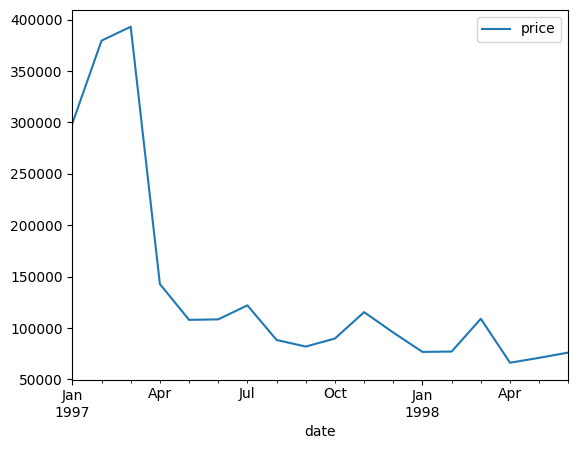

In [13]:
# Visualize: All purchases within cohort
cdnow_df \
    .reset_index() \
    .set_index('date') \
    [['price']] \
    .resample(
        rule = "MS"
    ) \
    .sum() \
    .plot()

In [14]:
# Individual Customer Purchases
ids = cdnow_df['customer_id'].unique()

In [15]:
ids

array([    1,     2,     3, ..., 23568, 23569, 23570], dtype=int64)

In [16]:
ids_selected = ids[0:10]

In [17]:
cdnow_cust_id_subset_df = cdnow_df \
    [cdnow_df['customer_id'].isin(ids_selected)] \
    .groupby(['customer_id', 'date']) \
    .sum() \
    .reset_index()

In [18]:
cdnow_df \
    [cdnow_df['customer_id'].isin(ids_selected)] \
    .groupby(['customer_id', 'date']) \
    .sum()

quantity   price
customer_id date                        
1           1997-01-01         1   11.77
2           1997-01-12         6   89.00
3           1997-01-02         2   20.76
            1997-03-30         2   20.76
            1997-04-02         2   19.54
            1997-11-15         5   57.45
            1997-11-25         4   20.96
            1998-05-28         1   16.99
4           1997-01-01         2   29.33
            1997-01-18         2   29.73
            1997-08-02         1   14.96
            1997-12-12         2   26.48
5           1997-01-01         2   29.33
            1997-01-14         1   13.97
            1997-02-04         3   38.90
            1997-04-11         3   45.55
            1997-05-31         3   38.71
            1997-06-16         2   26.14
            1997-07-22         2   28.14
            1997-09-15         3   40.47
            1997-12-08         4   46.46
            1997-12-12         3   40.47
            1998-01-03         3   37.47
6           1997-01-01         1   20.99
7           1997-01-01         2   28.74
            1997-10-11         7   97.43
            1998-03-22         9  138.50
8           1997-01-01         1    9.77
            1997-02-13         1   13.97
            1997-06-17         3   45.29
            1997-07-03         2   36.76
            1997-11-16         8   53.42
            1997-12-25         1   13.99
            1998-03-29         2   24.46
9           1997-01-01         2   23.54
            1997-05-13         2   30.33
            1998-06-08         2   41.98
10          1997-01-21         3   39.31

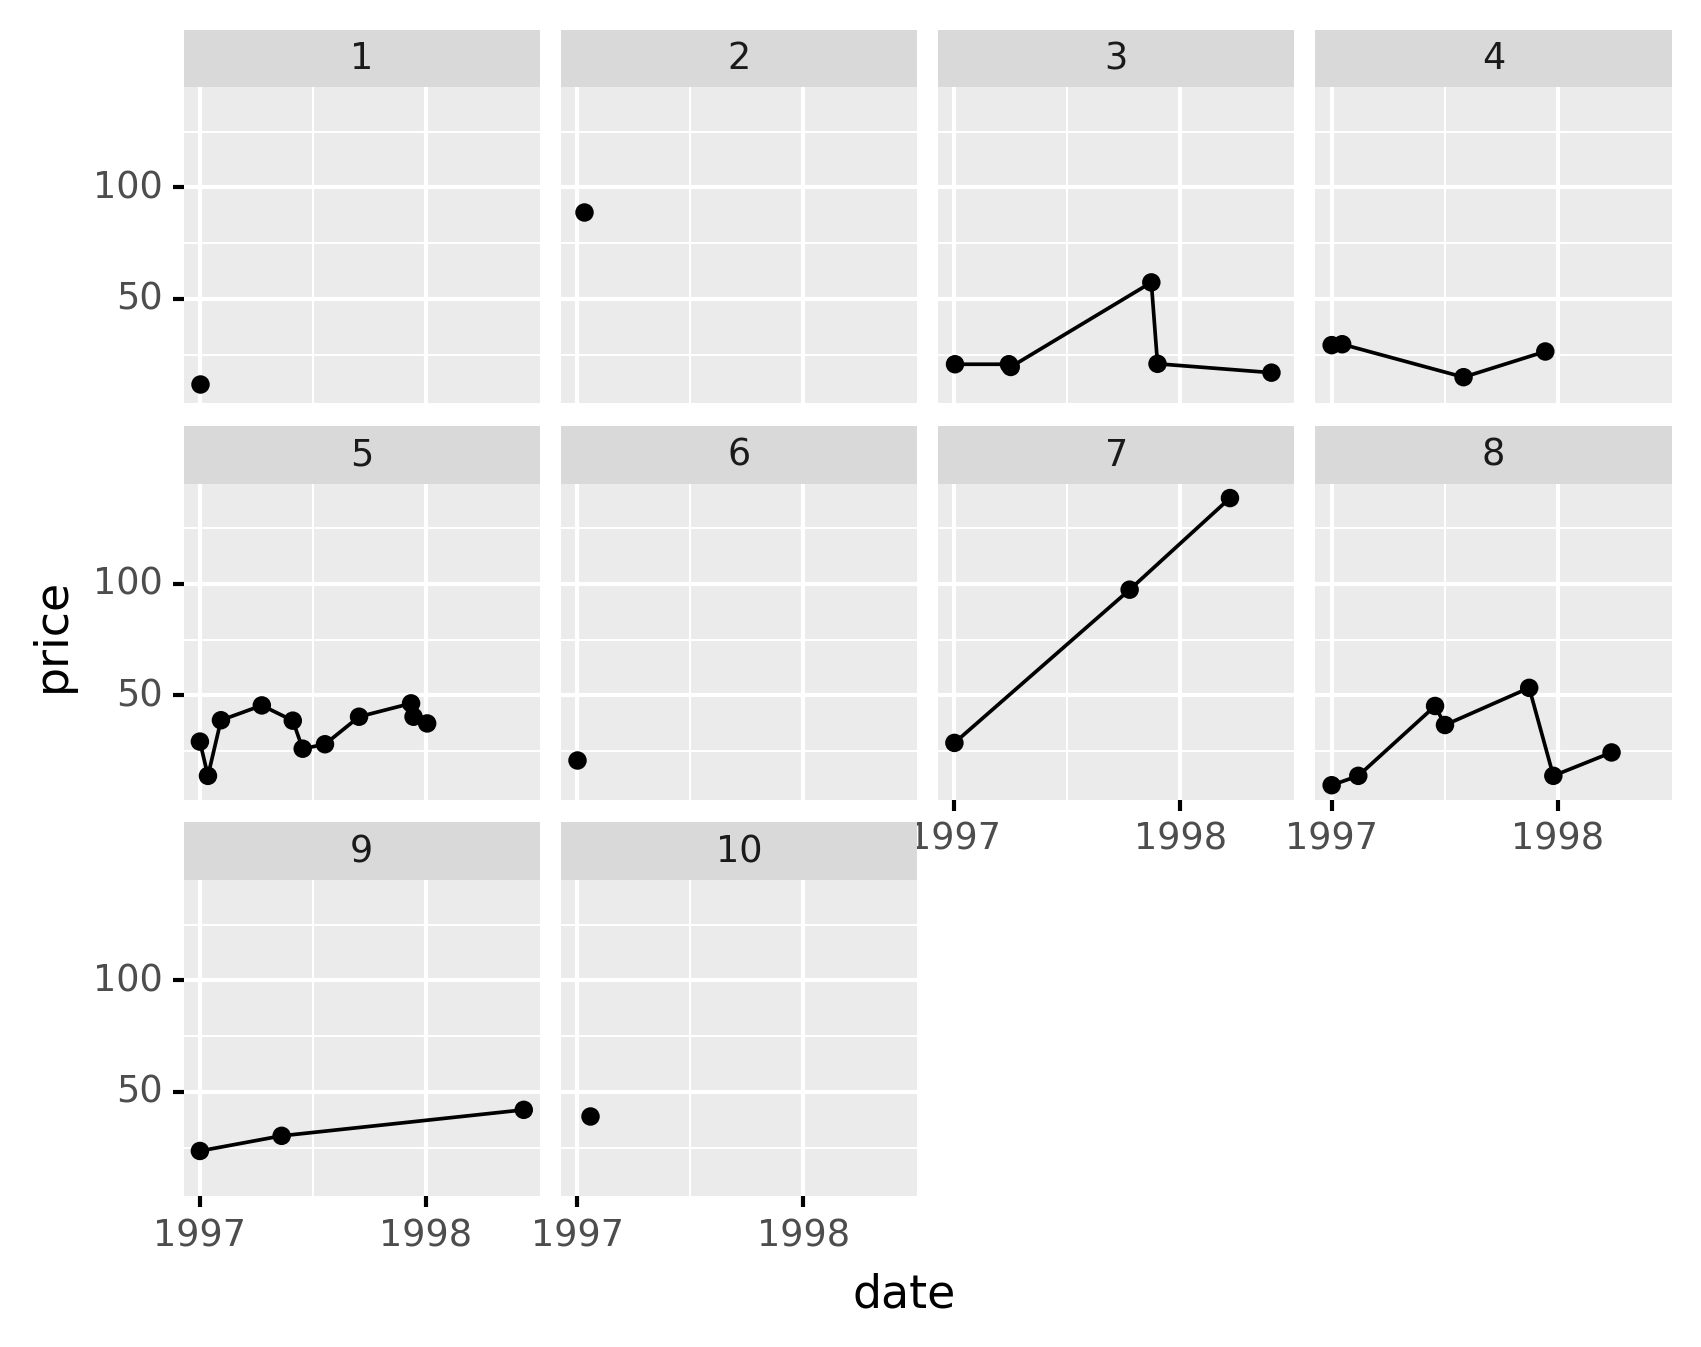

<ggplot: (-9223371965424137032)>

In [19]:
# Visualize: Individual Customer Purchases
pn.ggplot(
    pn.aes('date', 'price', group = 'customer_id'),
    data = cdnow_cust_id_subset_df
) \
    + pn.geom_line() \
    + pn.geom_point() \
    + pn.facet_wrap('customer_id') \
    + pn.scale_x_date(
        date_breaks = "1 year",
        date_labels = "%Y"
    )

# STEP 3 MACHINE LEARNING

- What will the customers spend in the next 90-Days? (Regression)
- What is the probability of a customer to make a purchase in next 90-days? (Classification)

## A) Time Splitting

In [20]:
n_days   = 90

In [21]:
max_date = cdnow_df['date'].max()

In [22]:
max_date

Timestamp('1998-06-30 00:00:00')

In [23]:
cutoff = max_date - pd.to_timedelta(n_days, unit = "d")

In [24]:
cutoff

Timestamp('1998-04-01 00:00:00')

In [25]:
# Before cutoff date
temporal_in_df = cdnow_df \
    [cdnow_df['date'] <= cutoff]

In [26]:
# After cutoff date
temporal_out_df = cdnow_df \
    [cdnow_df['date'] > cutoff]

In [27]:
temporal_out_df

,customer_id,date,quantity,price
8,3,1998-05-28,1,16.99
38,9,1998-06-08,2,41.98
68,25,1998-04-17,1,12.99
69,25,1998-05-25,1,10.49
70,25,1998-06-03,3,24.97
...,...,...,...,...
69583,23534,1998-05-02,1,10.48
69623,23555,1998-05-01,4,49.96
69624,23555,1998-06-10,2,27.48
69631,23556,1998-06-07,2,28.98


## B) Feature Engineering

In [28]:
# Make targets from out data
targets_df = temporal_out_df \
    .drop('quantity', axis=1) \
    .groupby('customer_id') \
    .sum() \
    .rename({'price': 'spend_90_total'}, axis = 1) \
    .assign(spend_90_flag = 1)

In [29]:
targets_df

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1
...,...,...
23529,40.56,1
23534,10.48,1
23555,77.44,1


In [30]:
# Make Recency (Date) Features from in data
# Next 90 days
max_date = temporal_in_df['date'].max()

In [31]:
max_date

Timestamp('1998-04-01 00:00:00')

In [32]:
recency_features_df = temporal_in_df \
    [['customer_id', 'date']] \
    .groupby('customer_id') \
    .apply(
        lambda x: (x['date'].max() - max_date) / pd.to_timedelta(1, "day")
    ) \
    .to_frame() \
    .set_axis(["recency"], axis=1)

In [33]:
# Date of last purchase
recency_features_df

,recency
customer_id,
1,-455.0
2,-444.0
3,-127.0
4,-110.0
5,-88.0
...,...
23566,-372.0
23567,-372.0
23568,-344.0


In [34]:
# Make Frequency (Count) Features from in data
frequency_features_df = temporal_in_df \
    [['customer_id', 'date']] \
    .groupby('customer_id') \
    .count() \
    .set_axis(['frequency'], axis=1)

In [35]:
frequency_features_df

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11
...,...
23566,1
23567,1
23568,3


In [36]:
# Make Price (Monetary) Features from in data 
price_features_df = temporal_in_df \
    .groupby('customer_id') \
    .aggregate(
        {
            'price': ["sum", "mean"]
        }
    ) \
    .set_axis(['price_sum', 'price_mean'], axis = 1)

In [37]:
price_features_df

,price_sum,price_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455
...,...,...
23566,36.00,36.000000
23567,20.97,20.970000
23568,121.70,40.566667


## C) Combine Features

In [38]:
# Place all features together
features_df = pd.concat(
    [recency_features_df, frequency_features_df, price_features_df], axis = 1
) \
    .merge(
        targets_df, 
        left_index  = True, 
        right_index = True, 
        how         = "left"
    ) \
    .fillna(0)

In [39]:
features_df

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455.0,1,11.77,11.770000,0.00,0.0
2,-444.0,2,89.00,44.500000,0.00,0.0
3,-127.0,5,139.47,27.894000,16.99,1.0
4,-110.0,4,100.50,25.125000,0.00,0.0
5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...
23566,-372.0,1,36.00,36.000000,0.00,0.0
23567,-372.0,1,20.97,20.970000,0.00,0.0
23568,-344.0,3,121.70,40.566667,0.00,0.0


# STEP 4 MACHINE LEARNING ALGORITHMS

In [40]:
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

## A) Next 90-Day Spend Prediction

In [41]:
y_spend = features_df['spend_90_total']

In [42]:
xgb_reg_spec = XGBRegressor(
    objective="reg:squarederror",   
    random_state=123
)

In [43]:
xgb_reg_model = GridSearchCV(
    estimator=xgb_reg_spec, 
    param_grid=dict(
        learning_rate = [0.01, 0.1, 0.3, 0.5]
    ),
    scoring = 'neg_mean_absolute_error',
    refit   = True,
    cv      = 5
)

In [44]:
xgb_reg_model.fit(X, y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,


In [45]:
xgb_reg_model.best_score_

-9.798940736745038

In [46]:
xgb_reg_model.best_params_

{'learning_rate': 0.01}

In [47]:
xgb_reg_model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)

In [48]:
predictions_reg = xgb_reg_model.predict(X)

In [49]:
predictions_reg

array([0.76148176, 1.7241197 , 8.92676   , ..., 3.2925851 , 0.8648808 ,
       2.1359034 ], dtype=float32)

## B) Next 90-Day Spend Probability

In [50]:
features_df['spend_90_flag']

customer_id
1        0.0
2        0.0
3        1.0
4        0.0
5        0.0
        ... 
23566    0.0
23567    0.0
23568    0.0
23569    0.0
23570    0.0
Name: spend_90_flag, Length: 23570, dtype: float64

In [51]:
y_prob = features_df['spend_90_flag']

In [52]:
xgb_clf_spec = XGBClassifier(
    objective    = "binary:logistic",   
    random_state = 123
)

In [53]:
xgb_clf_model = GridSearchCV(
    estimator=xgb_clf_spec, 
    param_grid=dict(
        learning_rate = [0.01, 0.1, 0.3, 0.5]
    ),
    scoring = 'roc_auc',
    refit   = True,
    cv      = 5
)

In [54]:
xgb_clf_model.fit(X, y_prob)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [55]:
xgb_clf_model.best_score_

0.8356414015855862

In [56]:
xgb_clf_model.best_params_

{'learning_rate': 0.01}

In [57]:
xgb_clf_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, ...)

In [58]:
predictions_clf = xgb_clf_model.predict_proba(X)

In [59]:
predictions_clf

array([[0.79955226, 0.20044775],
       [0.7899691 , 0.21003091],
       [0.6595424 , 0.34045762],
       ...,
       [0.7621703 , 0.23782966],
       [0.7955098 , 0.20449017],
       [0.77555573, 0.22444427]], dtype=float32)

In [60]:
X

,recency,frequency,price_sum,price_mean
customer_id,,,,
1,-455.0,1,11.77,11.770000
2,-444.0,2,89.00,44.500000
3,-127.0,5,139.47,27.894000
4,-110.0,4,100.50,25.125000
5,-88.0,11,385.61,35.055455
...,...,...,...,...
23566,-372.0,1,36.00,36.000000
23567,-372.0,1,20.97,20.970000
23568,-344.0,3,121.70,40.566667


## C) Global Feature Importance

In [61]:
# Importance | Spend Amount Model
imp_spend_amount_dict = xgb_reg_model \
    .best_estimator_ \
    .get_booster() \
    .get_score(importance_type = 'gain') 

In [62]:
imp_spend_amount_dict

{'recency': 161406.828125,
 'frequency': 149994.78125,
 'price_sum': 636200.0625,
 'price_mean': 34036.61328125}

In [63]:
imp_spend_amount_df = pd.DataFrame(
    data  = {
        'feature':list(imp_spend_amount_dict.keys()),
        'value':list(imp_spend_amount_dict.values())
    }
) \
    .assign(
        feature = lambda x: cat.cat_reorder(x['feature'] , x['value'])
    )

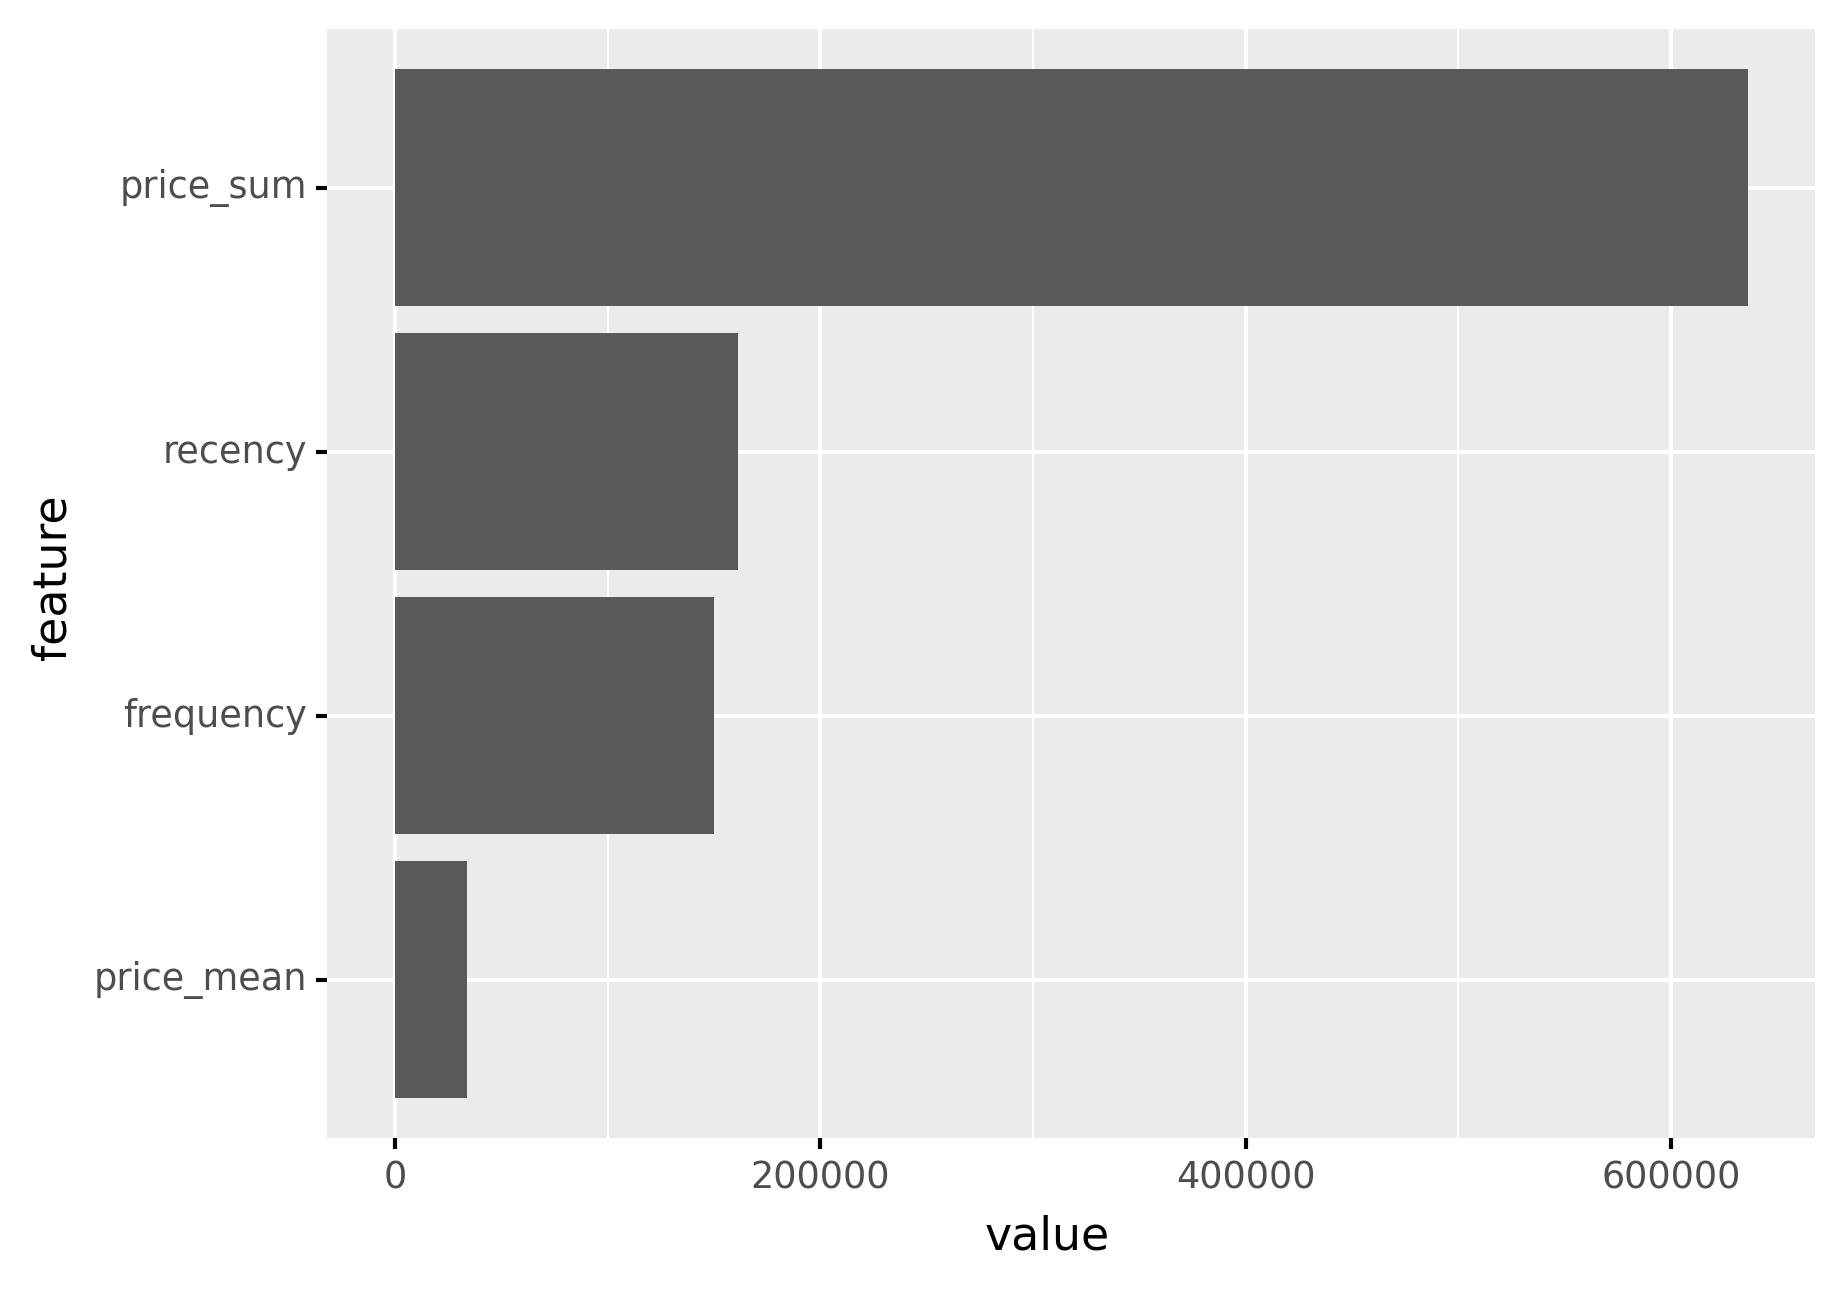

<ggplot: (-9223371965423764524)>

In [64]:
pn.ggplot(
    pn.aes('feature', 'value'),
    data = imp_spend_amount_df
) \
    + pn.geom_col() \
    + pn.coord_flip()

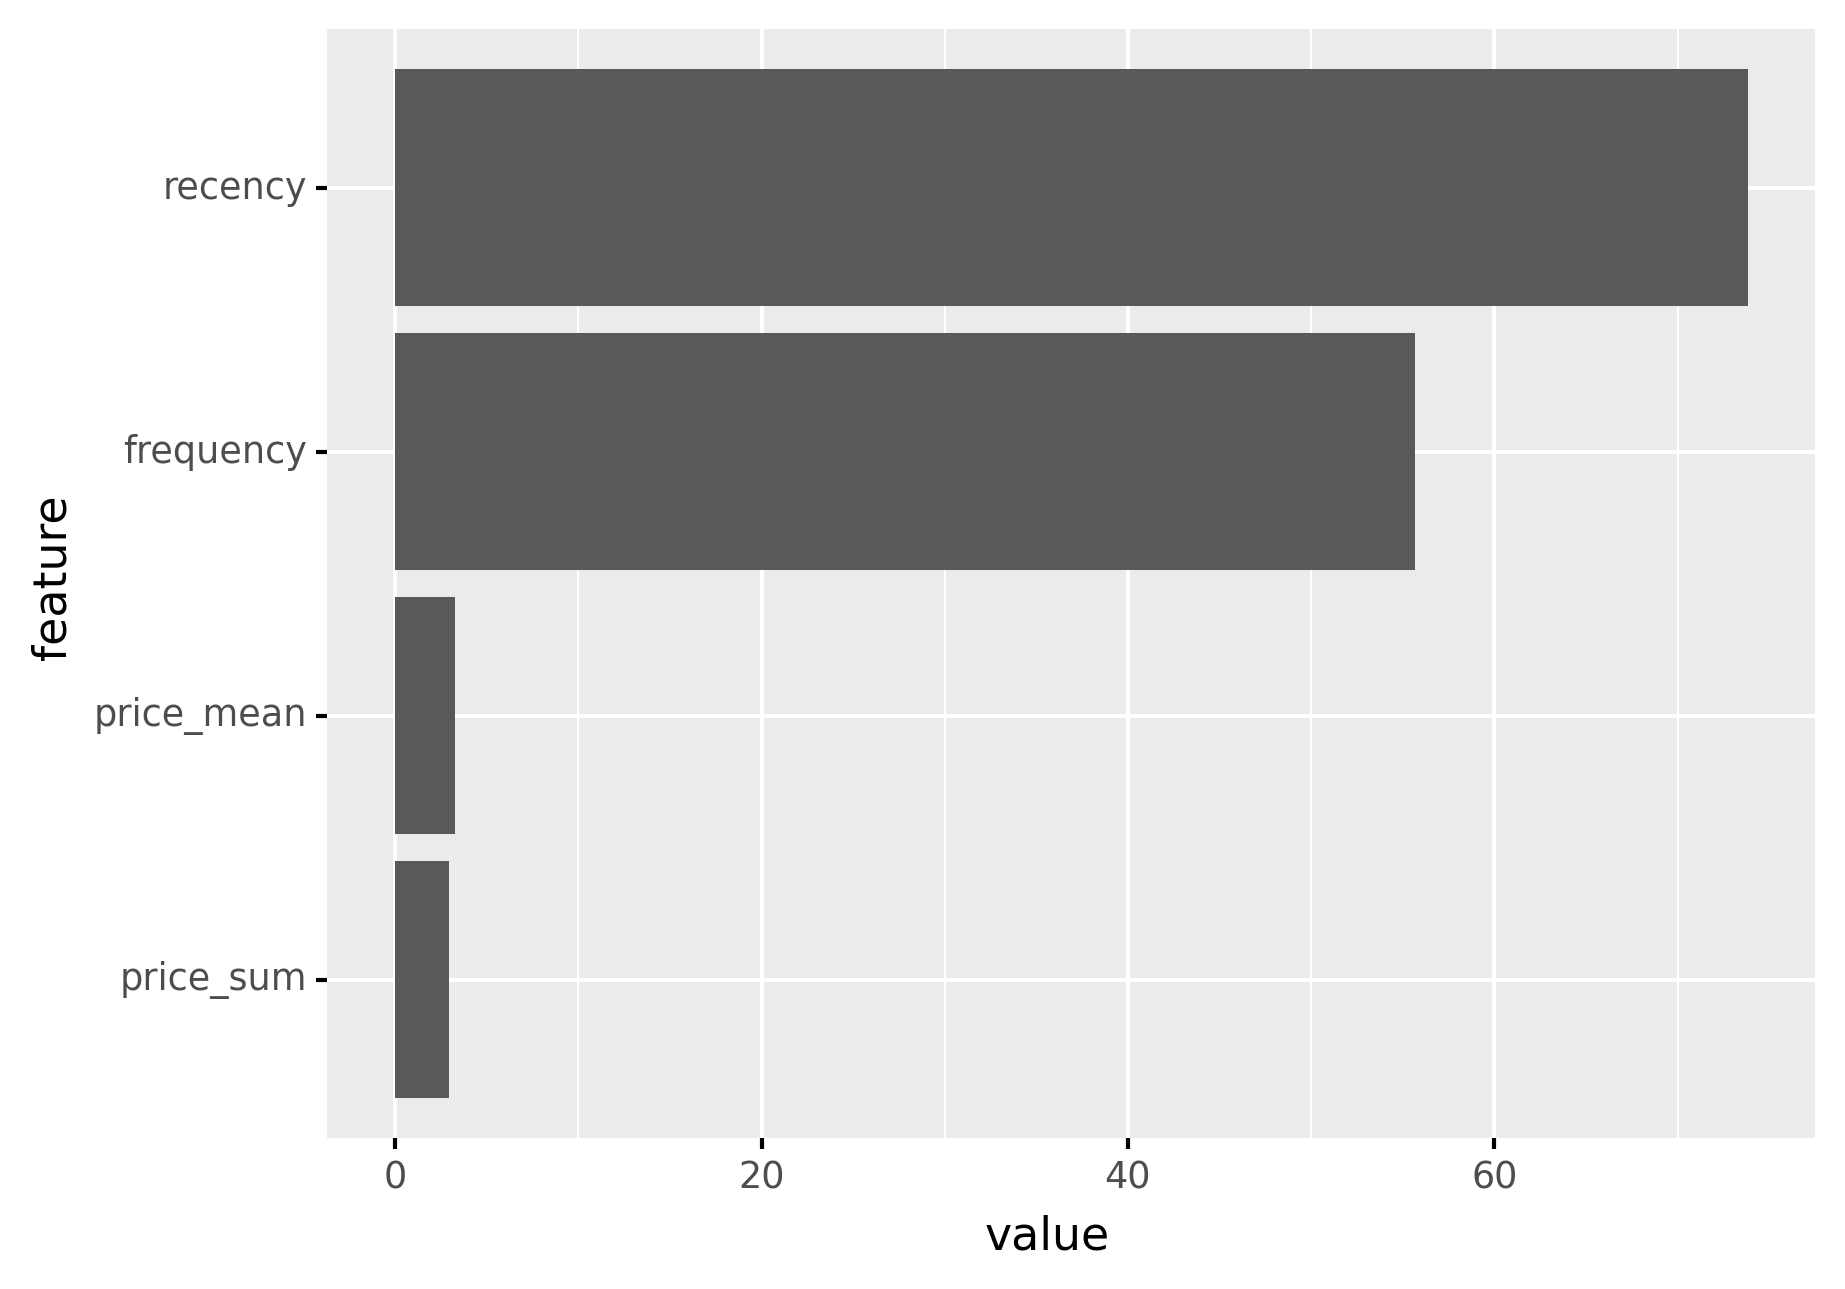

<ggplot: (-9223371965424156300)>

In [65]:
# Importance | Spend Probability Model
imp_spend_prob_dict = xgb_clf_model \
    .best_estimator_ \
    .get_booster() \
    .get_score(importance_type = 'gain') 

imp_spend_prob_df = pd.DataFrame(
    data  = {
        'feature':list(imp_spend_prob_dict.keys()),
        'value':list(imp_spend_prob_dict.values())
    }
) \
    .assign(
        feature = lambda x: cat.cat_reorder(x['feature'] , x['value'])
    )

pn.ggplot(
    pn.aes('feature', 'value'),
    data = imp_spend_prob_df
) \
    + pn.geom_col() \
    + pn.coord_flip() 

# STEP 5 SAVE PREDICTIONS

In [66]:
pd.DataFrame(predictions_reg).set_axis(['pred_spend'], axis=1)

,pred_spend
0,0.761482
1,1.724120
2,8.926760
3,7.594741
4,16.058043
...,...
23565,0.864881
23566,0.864881
23567,3.292585
23568,0.864881


In [67]:
pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'], axis=1)

,pred_prob
0,0.200448
1,0.210031
2,0.340458
3,0.340458
4,0.552980
...,...
23565,0.204490
23566,0.204490
23567,0.237830
23568,0.204490


In [68]:
predictions_df = pd.concat(
    [
        pd.DataFrame(predictions_reg).set_axis(['pred_spend'], axis=1),
        pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'], axis=1),
        features_df.reset_index()
    ], 
    axis=1
)

In [69]:
predictions_df

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,0.761482,0.200448,1,-455.0,1,11.77,11.770000,0.00,0.0
1,1.724120,0.210031,2,-444.0,2,89.00,44.500000,0.00,0.0
2,8.926760,0.340458,3,-127.0,5,139.47,27.894000,16.99,1.0
3,7.594741,0.340458,4,-110.0,4,100.50,25.125000,0.00,0.0
4,16.058043,0.552980,5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,0.864881,0.204490,23566,-372.0,1,36.00,36.000000,0.00,0.0
23566,0.864881,0.204490,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,3.292585,0.237830,23568,-344.0,3,121.70,40.566667,0.00,0.0
23568,0.864881,0.204490,23569,-372.0,1,25.74,25.740000,0.00,0.0


In [70]:
predictions_df.to_pickle("artifacts/predictions_df.pkl")
pd.read_pickle('artifacts/predictions_df.pkl')

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,0.761482,0.200448,1,-455.0,1,11.77,11.770000,0.00,0.0
1,1.724120,0.210031,2,-444.0,2,89.00,44.500000,0.00,0.0
2,8.926760,0.340458,3,-127.0,5,139.47,27.894000,16.99,1.0
3,7.594741,0.340458,4,-110.0,4,100.50,25.125000,0.00,0.0
4,16.058043,0.552980,5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,0.864881,0.204490,23566,-372.0,1,36.00,36.000000,0.00,0.0
23566,0.864881,0.204490,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,3.292585,0.237830,23568,-344.0,3,121.70,40.566667,0.00,0.0
23568,0.864881,0.204490,23569,-372.0,1,25.74,25.740000,0.00,0.0


In [71]:
# Save Importance
imp_spend_amount_df.to_pickle("artifacts/imp_spend_amount_df.pkl")
imp_spend_prob_df.to_pickle("artifacts/imp_spend_prob_df.pkl")

In [72]:
pd.read_pickle("artifacts/imp_spend_amount_df.pkl")

,feature,value
0,recency,161406.828125
1,frequency,149994.781250
2,price_sum,636200.062500
3,price_mean,34036.613281


In [73]:
# Save Models
joblib.dump(xgb_reg_model, 'artifacts/xgb_reg_model.pkl')
joblib.dump(xgb_clf_model, 'artifacts/xgb_clf_model.pkl')

['artifacts/xgb_clf_model.pkl']

In [74]:
model = joblib.load('artifacts/xgb_reg_model.pkl')

In [75]:
model.predict(X)

array([0.76148176, 1.7241197 , 8.92676   , ..., 3.2925851 , 0.8648808 ,
       2.1359034 ], dtype=float32)

# STEP 6 CONCLUSIONS
1) Which customers have the highest spend probability in next 90-days? 


In [76]:
# Target for new products similar to what they have purchased in the past
predictions_df \
    .sort_values('pred_prob', ascending=False)

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
22060,401.445709,0.782097,22061,-2.0,118,3371.80,28.574576,577.10,1.0
14047,1009.602539,0.782097,14048,0.0,180,7267.15,40.373056,1709.18,1.0
12859,176.101990,0.782097,12860,-3.0,30,1389.08,46.302667,457.26,1.0
709,141.295868,0.782097,710,-2.0,51,2216.45,43.459804,285.85,1.0
7591,1009.602539,0.782097,7592,-2.0,165,11478.02,69.563758,2512.91,1.0
...,...,...,...,...,...,...,...,...,...
8601,0.801216,0.200448,8602,-424.0,1,20.99,20.990000,0.00,0.0
8603,0.761482,0.200448,8604,-424.0,1,19.75,19.750000,0.00,0.0
8610,1.461973,0.200448,8611,-423.0,1,56.69,56.690000,0.00,0.0
8611,0.761482,0.200448,8612,-423.0,1,13.97,13.970000,0.00,0.0


2) Which customers have recently purchased but are unlikely to buy?

In [77]:
# Incentivize actions to increase probability
# Provide discounts, encourage referring a friend, nurture by letting them know what's coming
predictions_df \
    [(predictions_df['recency'] > -90) & (predictions_df['pred_prob'] < 0.3)]\
    .sort_values('pred_prob', ascending=False)

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
14018,64.629868,0.299600,14019,-24.0,2,177.52,88.760,437.52,1.0
8931,16.513412,0.299600,8932,-22.0,2,183.59,91.795,0.00,0.0
17883,3.681679,0.294981,17884,-56.0,2,31.95,15.975,0.00,0.0
19034,3.681679,0.294981,19035,-56.0,2,57.97,28.985,0.00,0.0
14090,3.681679,0.294981,14091,-56.0,2,33.34,16.670,27.87,1.0
...,...,...,...,...,...,...,...,...,...
7365,15.183114,0.256204,7366,-8.0,2,214.01,107.005,0.00,0.0
8077,15.731552,0.256204,8078,-12.0,2,327.93,163.965,0.00,0.0
15248,15.731552,0.256204,15249,-8.0,2,241.92,120.960,0.00,0.0
16100,15.183114,0.256204,16101,-23.0,2,213.62,106.810,0.00,0.0


3. Missed opportunities: Big spenders that could be unlocked

In [78]:
# Send bundle offers encouraging volume purchases
predictions_df \
    [
        predictions_df['spend_90_total'] == 0.0
    ] \
    .sort_values('pred_spend', ascending=False) 

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
21684,204.052017,0.682336,21685,-14.0,25,2031.06,81.242400,0.0,0.0
17522,162.689774,0.737004,17523,-5.0,17,2280.08,134.122353,0.0,0.0
17476,143.795929,0.640318,17477,-27.0,17,1248.14,73.420000,0.0,0.0
32,88.957130,0.688814,33,-19.0,25,1045.47,41.818800,0.0,0.0
4517,88.957130,0.655922,4518,-25.0,36,1053.91,29.275278,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5432,0.761482,0.200448,5433,-434.0,1,13.97,13.970000,0.0,0.0
0,0.761482,0.200448,1,-455.0,1,11.77,11.770000,0.0,0.0
22278,0.235517,0.675560,22279,-17.0,13,4490.64,345.433846,0.0,0.0
19338,0.235517,0.295011,19339,-355.0,56,6552.70,117.012500,0.0,0.0


Results will be exported to marketing team for targeted campaign applications. 
# This Is The End Of The Project, Thank You!